In [1]:
cd ..

/experiments_motion


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
sys.path.append('./Motion')
sys.path.append('./compare/DLow')

In [4]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import yaml
from tqdm import tqdm
from IPython.display import display, HTML

In [5]:
from motion import Motion
from motion import Quaternion
from h36m.skeleton import H36MSkeleton
from h36m.dataset.h36m_torch_dataset import H36MTorchDataset
from h36m.dataset.h36m_dataset import H36MDataset
from h36m.dataset.h36m_test_dataset import H36MTestDataset
from helper.helper import add_static_nodes
from motion_pred.eval import *

In [6]:
from metrics import MeanAngleL2Error, MeanPerJointPositionError, NegativeLogLikelihood

# Load H3.6M Skeleton

In [7]:
# Load skeleton configuration
with open('./config/h36m_skeleton_gen.yaml', 'r') as stream:
    skeleton = H36MSkeleton(**yaml.safe_load(stream))

## Define Eval Metrics

In [15]:
mae_l2_metric = MeanAngleL2Error(ignore_root=True) # We ignore the root rotation in the world for the origin joint
mpjpe_metric = MeanPerJointPositionError()
nll_metric = NegativeLogLikelihood()

In [16]:
t = [0.08, 0.16, 0.32, 0.4, 0.56, 0.72, 0.88, 1.]

## Load the Model

In [10]:
MODEL_PATH = './output/h36m/generative/'
CHECKPOINT = 'model'
CHECKPOINT_PATH = os.path.join(MODEL_PATH, CHECKPOINT + '.pth.tar')

In [11]:
# Load model config
with open(os.path.join(MODEL_PATH, 'config.yaml'), 'r') as file:
    model_config = yaml.safe_load(file)

In [12]:
model = Motion(skeleton, T=skeleton.nodes_type_id_dynamic, **model_config)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu')))
model.eval()
print('Model Loaded')

Model Loaded


In [25]:
def skeleton_set(skeleton, s):
    jl = []
    for i, p in enumerate(skeleton._parents):
        if p > -1:
            jl.append((s[i] - s[p]) * 1000.)
    l = torch.tensor(np.linalg.norm(np.array(jl), axis=-1))
    skeleton._offsets[skeleton._offsets.abs() > 0.] = l[l.abs() > 0.] * torch.sign(skeleton._offsets[skeleton._offsets.abs() > 0.])

## Load Evaluation Data

In [8]:
DATA_PATH = './data/processed/h3.6m.npz'

In [9]:
h36m_dataset = H36MDataset(DATA_PATH, dataset_fps=50, dataset_downsample_factor=1)

In [16]:
def sorted_modes(p_q):
    qs = p_q.component_distribution.M[..., -1, :]
    probs = p_q.mixture_distribution.probs
    w = probs
    probs_sorted, si = w.sort(-1, descending=True)
    si = si.repeat(1 ,qs.shape[1], qs.shape[2], 1)
    q_mode = qs.gather(dim=-2, index=si.unsqueeze(-1).repeat(1, 1, 1, 1, 4)).squeeze(-2)
    return q_mode

In [27]:
d = np.load('./compare/DLow/data/data_3d_h36m.npz', allow_pickle=True)
pos = d['positions_3d'].item()

In [28]:
ph = 100

In [29]:
dataset_eval_9 = H36MTorchDataset(h36m_dataset,
                                subjects=['S9'],
                                history_length=25,
                                prediction_horizon=ph,
                                step=25)
data_loader_eval = DataLoader(dataset_eval_9, shuffle=False, batch_size=128)
skeleton_set(skeleton, pos['S9']['Phoning'][100])

In [20]:
removed_joints = {0, 4, 5, 9, 10, 11, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31}
kept_joints = np.array([x for x in range(32) if x not in removed_joints])

In [21]:
n_samp = 50
y_pos_pred_l = []
y_pos_l = []
with torch.no_grad():
    for x, y in tqdm(data_loader_eval):
        # Remove static nodes
        x_dynamic = Quaternion.qfix_positive_(x[:, :, skeleton.dynamic_nodes])

        # Run Model 
        p_q, _, _, _ = model(x_dynamic, None, ph=ph)

        # The mode of the Distribution are the rotations
        q_samp = p_q.sample((50,)).permute(1, 0, 2, 3, 4)

        q_samp_all = add_static_nodes(q_samp, skeleton.static_nodes, skeleton.dynamic_nodes)
        
        pos_saml_all = skeleton(q_samp_all.reshape(-1, 32, 4), ignore_root=False).view(-1, n_samp, ph, 32, 3) / 1000.
        pos_saml_all = pos_saml_all[..., [0, 2, 1]] * torch.tensor([[[1., -1., 1.]]])
        pos_y = skeleton(y.view(-1, 32, 4), ignore_root=False).view(-1, ph, 32, 3) / 1000.
        pos_y = pos_y[..., [0, 2, 1]] * torch.tensor([[[1., -1., 1.]]])

        y_pos_pred_l.append(pos_saml_all[..., kept_joints, :])
        y_pos_l.append(pos_y[..., kept_joints, :])

y_pos_pred_9 = torch.cat(y_pos_pred_l, dim=0)
y_pos_9 = torch.cat(y_pos_l, dim=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [08:18<00:00, 20.77s/it]


In [22]:
dataset_eval_11 = H36MTorchDataset(h36m_dataset,
                                subjects=['S11'],
                                history_length=25,
                                prediction_horizon=ph,
                                skip_11_d=True,
                                step=25)
data_loader_eval = DataLoader(dataset_eval_11, shuffle=False, batch_size=128)
skeleton_set(skeleton, pos['S11']['Phoning 2'][100])

In [23]:
n_samp = 50
y_pos_pred_l = []
y_pos_l = []
with torch.no_grad():
    for x, y in tqdm(data_loader_eval):
        # Remove static nodes
        x_dynamic = Quaternion.qfix_positive_(x[:, :, skeleton.dynamic_nodes])

        # Run Model 
        p_q, _, _, _ = model(x_dynamic, None, ph=ph)

        # The mode of the Distribution are the rotations
        q_samp = p_q.sample((50,)).permute(1, 0, 2, 3, 4)
        
        q_samp_all = add_static_nodes(q_samp, skeleton.static_nodes, skeleton.dynamic_nodes)
        
        pos_saml_all = skeleton(q_samp_all.view(-1, 32, 4), ignore_root=False).view(-1, n_samp, ph, 32, 3) / 1000.
        pos_saml_all = pos_saml_all[..., [0, 2, 1]] * torch.tensor([[[1., -1., 1.]]])
        pos_y = skeleton(y.view(-1, 32, 4), ignore_root=False).view(-1, ph, 32, 3) / 1000.
        pos_y = pos_y[..., [0, 2, 1]] * torch.tensor([[[1., -1., 1.]]])

        y_pos_pred_l.append(pos_saml_all[..., kept_joints, :])
        y_pos_l.append(pos_y[..., kept_joints, :])

y_pos_pred_11 = torch.cat(y_pos_pred_l, dim=0)
y_pos_11 = torch.cat(y_pos_l, dim=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [05:44<00:00, 20.29s/it]


In [24]:
y_pos_pred = torch.cat([y_pos_pred_9, y_pos_pred_11], dim=0)
y_pos = torch.cat([y_pos_9, y_pos_11], dim=0)

In [25]:
del y_pos_pred_9
del y_pos_pred_11
del y_pos_9
del y_pos_11

In [26]:
y_pos.shape

torch.Size([5168, 100, 16, 3])

In [27]:
apd = 0.
for i in range(y_pos.shape[0]):
    apd += compute_diversity(y_pos_pred[i].flatten(start_dim=-2))

In [28]:
apd / y_pos.shape[0]

7.163445760617267

In [29]:
ade = 0.
for i in range(y_pos.shape[0]):
    ade += compute_ade(y_pos_pred[i].flatten(start_dim=-2), y_pos[i].flatten(start_dim=-2))

In [30]:
ade / y_pos.shape[0]

0.37481409221189815

In [31]:
fde = 0.
for i in range(y_pos.shape[0]):
    fde += compute_fde(y_pos_pred[i].flatten(start_dim=-2), y_pos[i].flatten(start_dim=-2))

In [32]:
fde / y_pos.shape[0]

0.487380185925716

In [37]:
from scipy.spatial.distance import pdist, squareform
t_his=25
def get_multimodal_gt(dataset):
    all_data = []
    for x, y in dataset:
        data = torch.cat([x, y], dim=0)
        all_data.append(data)
    all_data = torch.stack(all_data, axis=0)
    all_data = skeleton(all_data.view(-1, 32, 4)).view(-1, all_data.shape[1], 32, 3) / 1000.
    all_data = all_data[..., [0, 2, 1]] * torch.tensor([[[1., -1., 1.]]])
    all_data = all_data[..., kept_joints, :]
    all_start_pose = all_data[:, t_his - 1, :].flatten(start_dim=-2)
    pd = squareform(pdist(all_start_pose))
    traj_gt_arr = []
    for i in range(pd.shape[0]):
        ind = np.nonzero(pd[i] < 0.5)
        traj_gt_arr.append(all_data[ind][:, t_his:, :])
    return traj_gt_arr

In [38]:
skeleton_set(skeleton, pos['S9']['Phoning'][100])
m_gt_9 = get_multimodal_gt(dataset_eval_9)
skeleton_set(skeleton, pos['S11']['Phoning 2'][100])
m_gt_11 = get_multimodal_gt(dataset_eval_11)
m_gt = m_gt_9 + m_gt_11

In [39]:
mmade = 0.
for i in tqdm(range(y_pos.shape[0])):
    mmade += compute_mmade(y_pos_pred[i].flatten(start_dim=-2), None, m_gt[i].flatten(start_dim=-2))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5168/5168 [02:56<00:00, 29.35it/s]


In [40]:
mmade / y_pos.shape[0]

0.509119278065076

In [36]:
mmfde = 0.
for i in tqdm(range(y_pos.shape[0])):
    mmfde += compute_mmfde(y_pos_pred[i].flatten(start_dim=-2), None, m_gt[i].flatten(start_dim=-2))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5168/5168 [02:33<00:00, 33.71it/s]


In [37]:
mmfde / y_pos.shape[0]

0.5388977231873032

In [38]:
apd = 0.
for i in range(y_pos.shape[0]):
    apd += compute_diversity(y_pos_pred[i, :50, :50].flatten(start_dim=-2))

In [39]:
apd / y_pos.shape[0]

3.4532950575786745

In [40]:
ade = 0.
for i in range(y_pos.shape[0]):
    ade += compute_ade(y_pos_pred[i, :50, :50].flatten(start_dim=-2), y_pos[i, :50].flatten(start_dim=-2))

In [41]:
ade / y_pos.shape[0]

0.25154513040205734

In [42]:
fde = 0.
for i in range(y_pos.shape[0]):
    fde += compute_fde(y_pos_pred[i, :50, :50].flatten(start_dim=-2), y_pos[i, :50].flatten(start_dim=-2))

In [43]:
fde / y_pos.shape[0]

0.3497034123516281

In [44]:
mmade = 0.
for i in tqdm(range(y_pos.shape[0])):
    mmade += compute_mmade(y_pos_pred[i, :50, :50].flatten(start_dim=-2), None, m_gt[i][:, :50].flatten(start_dim=-2))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5168/5168 [01:30<00:00, 57.07it/s]


In [45]:
mmade / y_pos.shape[0]

0.44253856642604245

In [46]:
mmfde = 0.
for i in tqdm(range(y_pos.shape[0])):
    mmfde += compute_mmfde(y_pos_pred[i, :50, :50].flatten(start_dim=-2), None, m_gt[i][:, :50].flatten(start_dim=-2))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5168/5168 [01:21<00:00, 63.08it/s]


In [47]:
mmfde / y_pos.shape[0]

0.45430570652985214

## Multi Modal Metrics Evaluation

In [27]:
from scipy.spatial.distance import pdist, squareform
t_his=25
def get_multimodal_gt(dataset, threshold):
    all_data = []
    for x, y in dataset:
        data = torch.cat([x, y], dim=0)
        all_data.append(data)
    all_data = torch.stack(all_data, axis=0)
    all_data = skeleton(all_data.view(-1, 32, 4)).view(-1, all_data.shape[1], 32, 3) / 1000.
    all_data = all_data[..., [0, 2, 1]] * torch.tensor([[[1., -1., 1.]]])
    all_data = all_data[..., kept_joints, :]
    all_start_pose = all_data[:, t_his - 1, :].flatten(start_dim=-2)
    pd = squareform(pdist(all_start_pose))
    traj_gt_arr = []
    for i in range(pd.shape[0]):
        ind = np.nonzero(pd[i] < threshold)
        traj_gt_arr.append(all_data[ind][:, t_his:, :])
    return traj_gt_arr

In [30]:
mmade_list = []
mmfde_list = []
with torch.no_grad():
    for t in [0.1, 0.2, 0.3, 0.4, 0.5]:
        skeleton_set(skeleton, pos['S9']['Phoning'][100])
        m_gt_9 = get_multimodal_gt(dataset_eval_9, t)
        skeleton_set(skeleton, pos['S11']['Phoning 2'][100])
        m_gt_11 = get_multimodal_gt(dataset_eval_11, t)
        m_gt = m_gt_9 + m_gt_11

        mmade = 0.
        for i in tqdm(range(y_pos.shape[0])):
            mmade += compute_mmade(y_pos_pred[i].flatten(start_dim=-2), None, m_gt[i].flatten(start_dim=-2))
        mmade_list.append(mmade / y_pos.shape[0])

        mmfde = 0.
        for i in tqdm(range(y_pos.shape[0])):
            mmfde += compute_mmfde(y_pos_pred[i].flatten(start_dim=-2), None, m_gt[i].flatten(start_dim=-2))
        mmfde_list.append(mmfde / y_pos.shape[0])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5168/5168 [02:48<00:00, 30.64it/s]


In [31]:
print(mmade_list)
print(mmfde_list)

[0.37662269188748565, 0.387762265209247, 0.4203940319609554, 0.46379160716691437, 0.5088552698614105]
[0.4877161071188863, 0.48913437380648617, 0.49805025508102524, 0.5165281021367794, 0.5385081663370225]


In [1]:
t = [0.1, 0.2, 0.3, 0.4, 0.5]
mmade_list = [0.37662269188748565, 0.387762265209247, 0.4203940319609554, 0.46379160716691437, 0.5088552698614105]
mmfde_list = [0.4877161071188863, 0.48913437380648617, 0.49805025508102524, 0.5165281021367794, 0.5385081663370225]
mmade_list_dlow = [0.41866363429582615, 0.42348777630507667, 0.43801822789278655, 0.459772969079968, 0.4856139307916626]
mmfde_list_dlow = [0.5127856655870983, 0.5126198851950351, 0.5158396173649159, 0.5196737145065062, 0.5255972387344107]

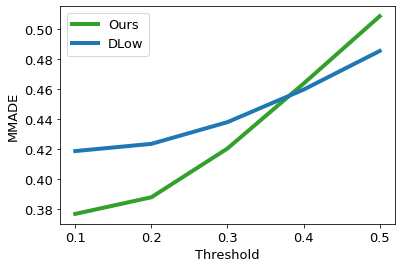

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
plt.plot(t, mmade_list, c='#33A02C', label='Ours', linewidth=4)
plt.plot(t, mmade_list_dlow, c='#1F78B4', label='DLow', linewidth=4)
plt.legend()
plt.gca().set_xlabel('Threshold')
plt.gca().set_ylabel('MMADE')
plt.savefig('./mmade.pdf', bbox_inches='tight', dpi=300)

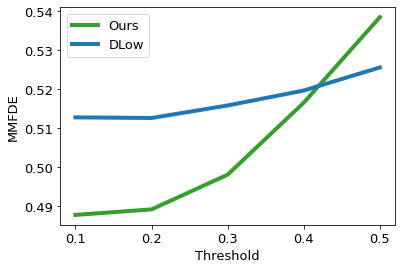

In [7]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
plt.plot(t, mmfde_list, c='#33A02C', label='Ours', linewidth=4)
plt.plot(t, mmfde_list_dlow, c='#1F78B4', label='DLow', linewidth=4)
plt.legend()
plt.gca().set_xlabel('Threshold')
plt.gca().set_ylabel('MMFDE')
plt.savefig('./mmfde.pdf', bbox_inches='tight', dpi=300)

In [43]:
from scipy.spatial.distance import pdist, squareform
t_his=25
def get_multimodal_gt(dataset):
    all_data = []
    for x, y in dataset:
        data = torch.cat([x, y], dim=0)
        all_data.append(data)
    all_data = torch.stack(all_data, axis=0)
    all_data = skeleton(all_data.view(-1, 32, 4)).view(-1, all_data.shape[1], 32, 3) / 1000.
    all_data = all_data[..., [0, 2, 1]] * torch.tensor([[[1., -1., 1.]]])
    all_data = all_data[..., kept_joints, :]
    all_start_pose = all_data[:, t_his - 1, :].flatten(start_dim=-2)
    pd = squareform(pdist(all_start_pose))
    traj_gt_arr = []
    for i in range(pd.shape[0]):
        ind = np.nonzero((pd[i] < 0.5) & (pd[i] > 0.45))
        print(i)
        print(ind)
        assert False
    return traj_gt_arr

In [44]:
skeleton_set(skeleton, pos['S9']['Phoning'][100])
m_gt_9 = get_multimodal_gt(dataset_eval_9)

0
(array([1281, 1352, 1354, 1355, 1418]),)


AssertionError: 

In [22]:
import matplotlib.pyplot as plt
import time
%matplotlib notebook

In [23]:
ids = [0, 1281, 1352, 1354, 1355, 1418]

In [24]:
dataset_eval_9 = H36MTorchDataset(h36m_dataset,
                                subjects=['S9'],
                                history_length=25,
                                prediction_horizon=100,
                                step=25)

<IPython.core.display.Javascript object>


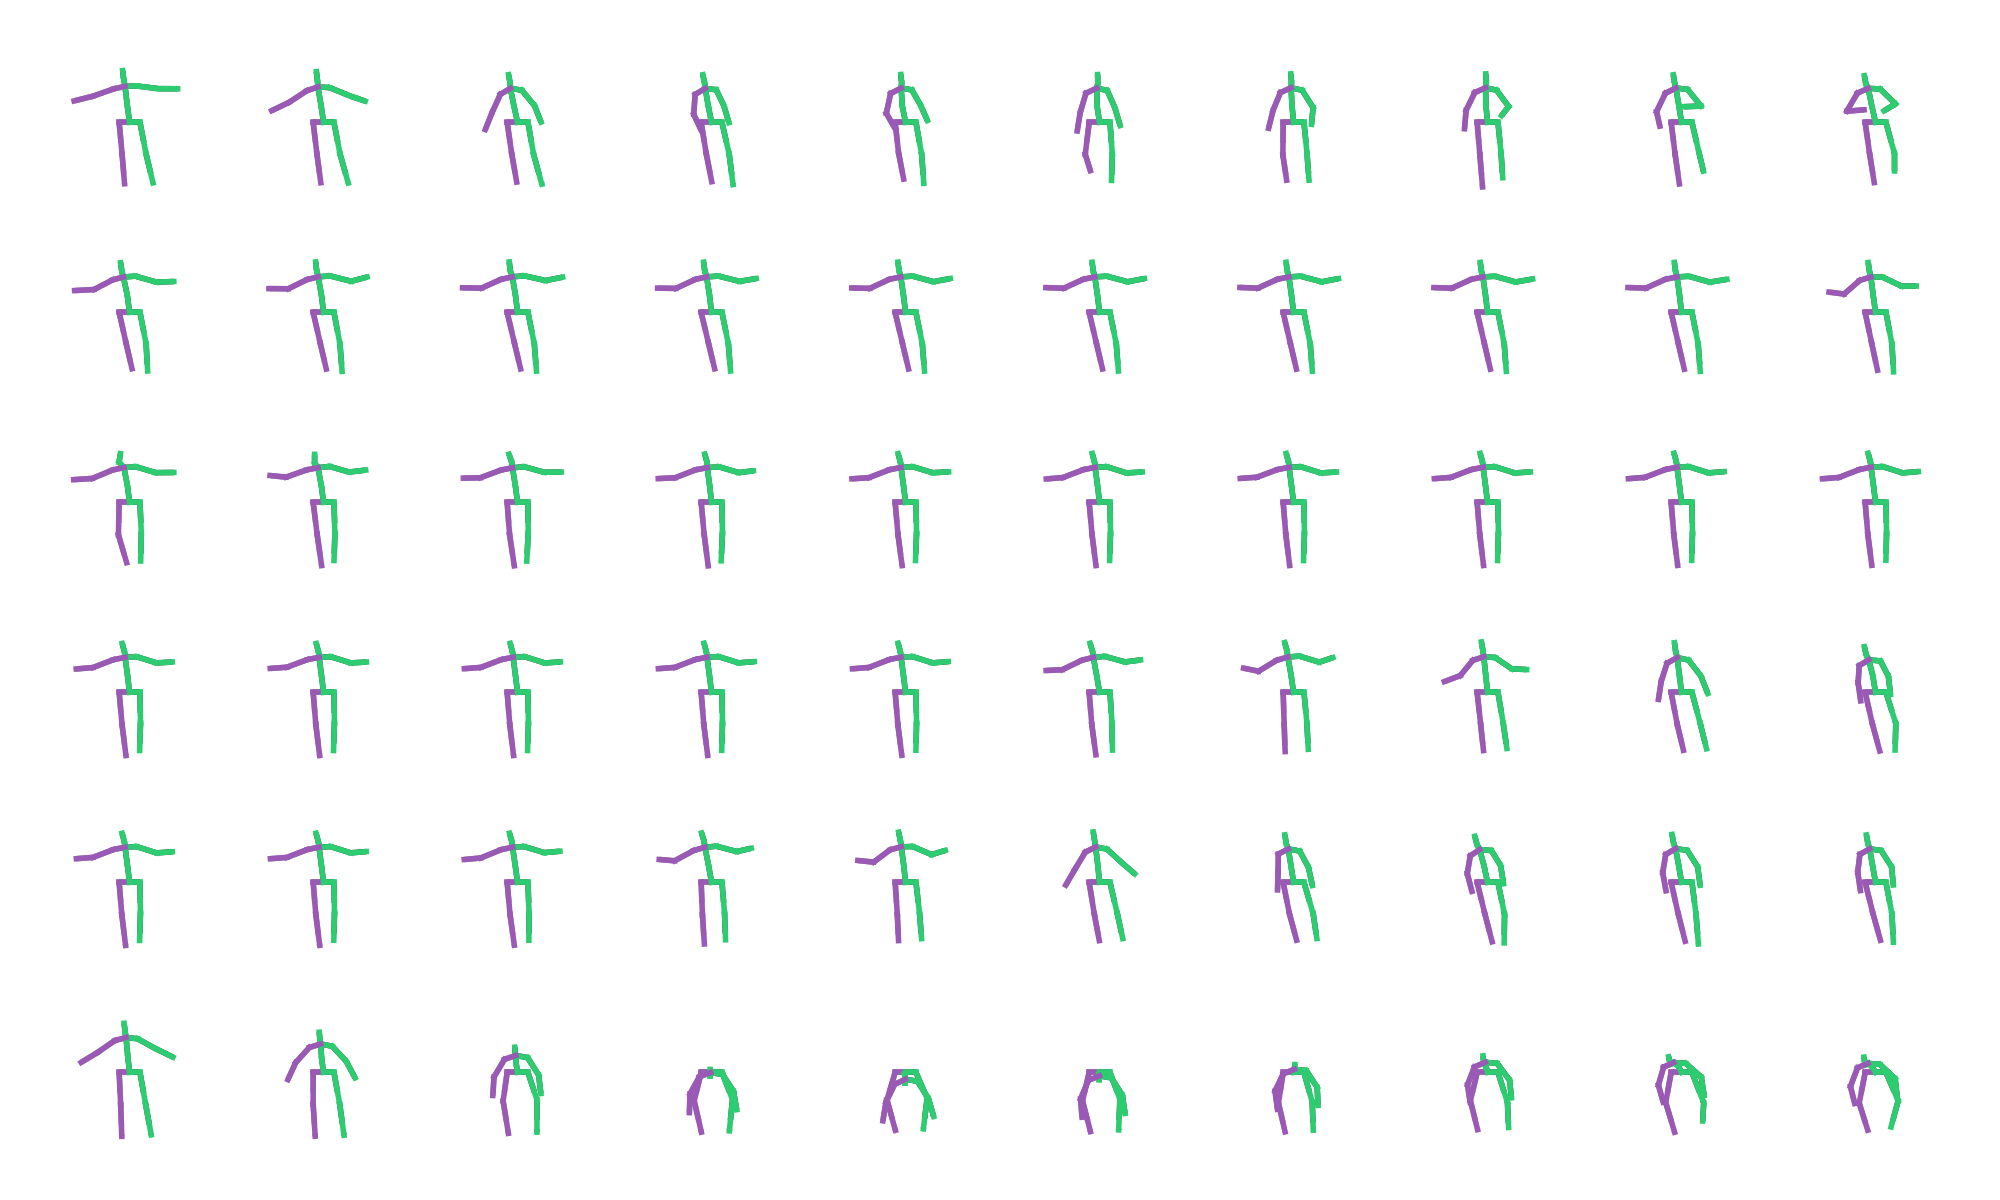

0
1281
1352
1354
1355
1418


In [44]:
fig = plt.figure(figsize=(10, 6))
a = 1
for j, id in enumerate(ids):
    print(id)
    x, y = dataset_eval_9[id]
    # Needed for VIZ
    y = Quaternion(y).axis_angle
    y = Quaternion(axis=-y, angle=y.norm(dim=-1)).q
    
    p = skeleton(y.view(-1, 32, 4)).view(-1, y.shape[0], 32, 3)[0]
    for i in range(0, p.shape[0], 10):
        ax = fig.add_subplot(6, 10, a, projection='3d')
        ob = Ax3DPose(ax)
        
        ax.get_legend().remove()
        ax.grid(False)

        
        ob.update(p[i].numpy(), p[i].numpy())
        
        ax.axis('off')
        
        a += 1
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
fig.canvas.draw()
fig.show()
fig.savefig('./error_comp_y.png', bbox_inches='tight', dpi=500)

In [12]:
class Ax3DPose(object):
    def __init__(self, ax, lcolor="#3498db", rcolor="#e74c3c", label=['GT', 'Pred']):
        """
        Create a 3d pose visualizer that can be updated with new poses.

        Args
          ax: 3d axis to plot the 3d pose on
          lcolor: String. Colour for the left part of the body
          rcolor: String. Colour for the right part of the body
        """

        # Start and endpoints of our representation
        self.I = np.array([1, 2, 3, 1, 7, 8, 1, 13, 14, 15, 14, 18, 19, 14, 26, 27]) - 1
        self.J = np.array([2, 3, 4, 7, 8, 9, 13, 14, 15, 16, 18, 19, 20, 26, 27, 28]) - 1
        # Left / right indicator
        self.LR = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)
        self.ax = ax

        vals = np.zeros((32, 3))

        # Make connection matrix
        self.plots = []
        for i in np.arange(len(self.I)):
            x = np.array([vals[self.I[i], 0], vals[self.J[i], 0]])
            y = np.array([vals[self.I[i], 1], vals[self.J[i], 1]])
            z = np.array([vals[self.I[i], 2], vals[self.J[i], 2]])
            if i == 0:
                self.plots.append(
                    self.ax.plot(x, z, y, lw=2, linestyle='--', c=rcolor if self.LR[i] else lcolor, label=label[0]))
            else:
                self.plots.append(self.ax.plot(x, y, z, lw=2, linestyle='--', c=rcolor if self.LR[i] else lcolor))

        self.plots_pred = []
        for i in np.arange(len(self.I)):
            x = np.array([vals[self.I[i], 0], vals[self.J[i], 0]])
            y = np.array([vals[self.I[i], 1], vals[self.J[i], 1]])
            z = np.array([vals[self.I[i], 2], vals[self.J[i], 2]])
            if i == 0:
                self.plots_pred.append(self.ax.plot(x, y, z, lw=2, c=rcolor if self.LR[i] else lcolor, label=label[1]))
            else:
                self.plots_pred.append(self.ax.plot(x, y, z, lw=2, c=rcolor if self.LR[i] else lcolor))

        self.ax.set_xlabel("x")
        self.ax.set_ylabel("y")
        self.ax.set_zlabel("z")
        # self.ax.set_axis_off()
        # self.ax.axes.get_xaxis().set_visible(False)
        # self.axes.get_yaxis().set_visible(False)
        self.ax.legend(loc='lower left')
        self.ax.view_init(120, -90)

    def update(self, gt_channels, pred_channels):
        """
        Update the plotted 3d pose.

        Args
          channels: 96-dim long np array. The pose to plot.
          lcolor: String. Colour for the left part of the body.
          rcolor: String. Colour for the right part of the body.
        Returns
          Nothing. Simply updates the axis with the new pose.
        """

        assert gt_channels.size == 96, "channels should have 96 entries, it has %d instead" % gt_channels.size
        gt_vals = np.reshape(gt_channels, (32, -1))
        lcolor = "#8e8e8e"
        rcolor = "#383838"
        for i in np.arange(len(self.I)):
            x = np.array([gt_vals[self.I[i], 0], gt_vals[self.J[i], 0]])
            y = np.array([gt_vals[self.I[i], 1], gt_vals[self.J[i], 1]])
            z = np.array([gt_vals[self.I[i], 2], gt_vals[self.J[i], 2]])
            self.plots[i][0].set_xdata(x)
            self.plots[i][0].set_ydata(y)
            self.plots[i][0].set_3d_properties(z)
            self.plots[i][0].set_color(lcolor if self.LR[i] else rcolor)
            # self.plots[i][0].set_alpha(0.5)

        assert pred_channels.size == 96, "channels should have 96 entries, it has %d instead" % pred_channels.size
        pred_vals = np.reshape(pred_channels, (32, -1))
        lcolor = "#9b59b6"
        rcolor = "#2ecc71"
        for i in np.arange(len(self.I)):
            x = np.array([pred_vals[self.I[i], 0], pred_vals[self.J[i], 0]])
            y = np.array([pred_vals[self.I[i], 1], pred_vals[self.J[i], 1]])
            z = np.array([pred_vals[self.I[i], 2], pred_vals[self.J[i], 2]])
            self.plots_pred[i][0].set_xdata(x)
            self.plots_pred[i][0].set_ydata(y)
            self.plots_pred[i][0].set_3d_properties(z)
            self.plots_pred[i][0].set_color(lcolor if self.LR[i] else rcolor)
            # self.plots_pred[i][0].set_alpha(0.7)

        r = 750
        xroot, yroot, zroot = gt_vals[0, 0], gt_vals[0, 1], gt_vals[0, 2]
        self.ax.set_xlim3d([-r + xroot, r + xroot])
        self.ax.set_zlim3d([-r + zroot, r + zroot])
        self.ax.set_ylim3d([-r + yroot, r + yroot])
        self.ax.set_aspect('auto')